Problem statement:

Situation: Energy is produced in different forms and consumed by the regions in different rates.   

Complication: Energy prices are increasing due to many reasons including but not limited to war, logistics and sanctions.   

Question: Is it possible to see what types of energy have been historically produced and consumed by the different regions? Is it possible to predict how the productions and consumption will look like in the future?   

Answer: ???


In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid', palette='crest')
import matplotlib.pyplot as plt


from sklearn.datasets import load_diabetes  # our diabetes dataset
from sklearn.model_selection import (
    train_test_split,
)  # will allow us to helpfully subdivide our data
from sklearn.linear_model import (
    LinearRegression,
)  # a simple model we can play around with

from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.base import ForecastingHorizon


from sktime.forecasting.theta import ThetaForecaster


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
leveranser_flytande = pd.read_table('../data/to-use/leveranser-flytande-bransle-region-ar.csv', sep=',')
elproduction_bransleanvandning = pd.read_table('../data/to-use/elproduction-bransleanvandning-region-produktionssatt-bransletyp-ar.csv', sep=',')
fjarrvarmeproduktion = pd.read_table('../data/to-use/fjarrvarmeproduktion-region-produktionssatt-bransletyp-ar.csv', sep=',')
slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')
bransleforbrukning = pd.read_table('../data/to-use/branslefarbrukning-far-produktion-per-ar.csv', sep=',')
energidata = pd.read_table('../data/to-use/energidata-per-ar.csv', sep=',')

datasets = [leveranser_flytande, elproduction_bransleanvandning, 
            fjarrvarmeproduktion, slutanvandning, bransleforbrukning, energidata]


## FIll NAs
leveranser_flytande.m3 = leveranser_flytande.m3.fillna(method='ffill')
fjarrvarmeproduktion.MWh = fjarrvarmeproduktion.MWh.interpolate()
# slutanvandning = slutanvandning.fillna('fffill')
energidata.MWh = energidata.MWh.fillna(method='ffill')


# Slice dataset for regions
leveranser_flytande = leveranser_flytande[leveranser_flytande.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
elproduction_bransleanvandning = elproduction_bransleanvandning[elproduction_bransleanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion[fjarrvarmeproduktion.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
slutanvandning = slutanvandning[slutanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
energidata = energidata[energidata.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)


## Group datasets
leveranser_flytande = leveranser_flytande.groupby(['region', 'ar', 'fornybar_bransletyp'], as_index=False).agg(Sum=('m3', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)
elproduction_bransleanvandning_grouped = elproduction_bransleanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)
slutanvandning = slutanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'forbrukarkategori'], as_index=False).agg(Sum=('MWh', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)
bransleforbrukning = bransleforbrukning.groupby(['ar', 'fornybar_bransletyp', 'produktionsslag'], as_index=False).agg( Sum=('branslefarbrukning', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)
energidata = energidata.groupby(['region', 'ar', 'fornybar_energityp', 'fornybar_kategori'], as_index=False).agg(Sum=('MWh', np.sum)).sort_values(by=['Sum']).reset_index(drop=True)


leveranser_flytande.ar = pd.to_datetime(leveranser_flytande.ar, format='%Y-%m-%d').dt.year
elproduction_bransleanvandning_grouped.ar = pd.to_datetime(elproduction_bransleanvandning_grouped.ar, format='%Y-%m-%d').dt.year
fjarrvarmeproduktion.ar = pd.to_datetime(fjarrvarmeproduktion.ar, format='%Y-%m-%d').dt.year
slutanvandning.ar = pd.to_datetime(slutanvandning.ar, format='%Y-%m-%d').dt.year
bransleforbrukning.ar = pd.to_datetime(bransleforbrukning.ar, format='%Y-%m-%d').dt.year
energidata.ar = pd.to_datetime(energidata.ar, format='%Y-%m-%d').dt.year



C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_21904\3935031558.py:4: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')


In [15]:
# Constants

AR = 'ar'
M3 = 'm3'
MWH = 'MWh'

BRANSLETYP = 'bransletyp'
FARBRUKARKATEGORI = 'farbrukarkategori'
PRODUCTIONSSATT = 'produktionssatt'
KATEGORI = 'kategori'
ENERGITYP = 'energityp'
PRODUCTIONSSLAG = 'produktionsslag'
BRANSLEFORBRUKNING = 'bransleforbukning'

REGION = 'region'

FORNYBAR_BRANSLETYP = 'fornybar_bransletyp'
FORNYBAR_PRODUCTIONSSATT = 'fornybar_produktionssatt'
FORNYBAR_PRODUCTIONSSLAG = 'fornybar_produktionssatt'
FORNYBAR_ENERGITYP = 'fornybar_energityp'
FORNYBAR_KATEGORI = 'fornybar_kategori'


In [16]:
encodeList = [REGION, FORNYBAR_BRANSLETYP, FORNYBAR_PRODUCTIONSSATT, FORNYBAR_PRODUCTIONSSLAG, FORNYBAR_ENERGITYP, FORNYBAR_KATEGORI]

In [18]:
for encode_item in encodeList:
    if encode_item in leveranser_flytande.columns:
        leveranser_flytande[encode_item].replace(leveranser_flytande[encode_item].unique(), range(
            0, len(leveranser_flytande[encode_item].unique())), inplace=True)

In [14]:
# split our data - by loading X and y we get a frame of all our patient attributes (age, sex serum etc) and a seperate frame of outcomes
(
    attributes_train,
    attributes_test,
    progression_train,
    progression_test,
) = train_test_split(leveranser_flytande, leveranser_flytande.Sum, test_size=0.33)

# Instantiate
linear_regression = LinearRegression()

# Fit
linear_regression.fit(attributes_train, progression_train)

# Predict
progression_predict = linear_regression.predict(attributes_test)

ValueError: could not convert string to float: '09 Gotlands l�n'

In [13]:
progression

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
5       97.0
6      138.0
7       63.0
8      110.0
9      310.0
10     101.0
11      69.0
12     179.0
13     185.0
14     118.0
15     171.0
16     166.0
17     144.0
18      97.0
19     168.0
20      68.0
21      49.0
22      68.0
23     245.0
24     184.0
25     202.0
26     137.0
27      85.0
28     131.0
29     283.0
30     129.0
31      59.0
32     341.0
33      87.0
34      65.0
35     102.0
36     265.0
37     276.0
38     252.0
39      90.0
40     100.0
41      55.0
42      61.0
43      92.0
44     259.0
45      53.0
46     190.0
47     142.0
48      75.0
49     142.0
50     155.0
51     225.0
52      59.0
53     104.0
54     182.0
55     128.0
56      52.0
57      37.0
58     170.0
59     170.0
60      61.0
61     144.0
62      52.0
63     128.0
64      71.0
65     163.0
66     150.0
67      97.0
68     160.0
69     178.0
70      48.0
71     270.0
72     202.0
73     111.0
74      85.0
75      42.0
76     170.0

NaiveForecaster()

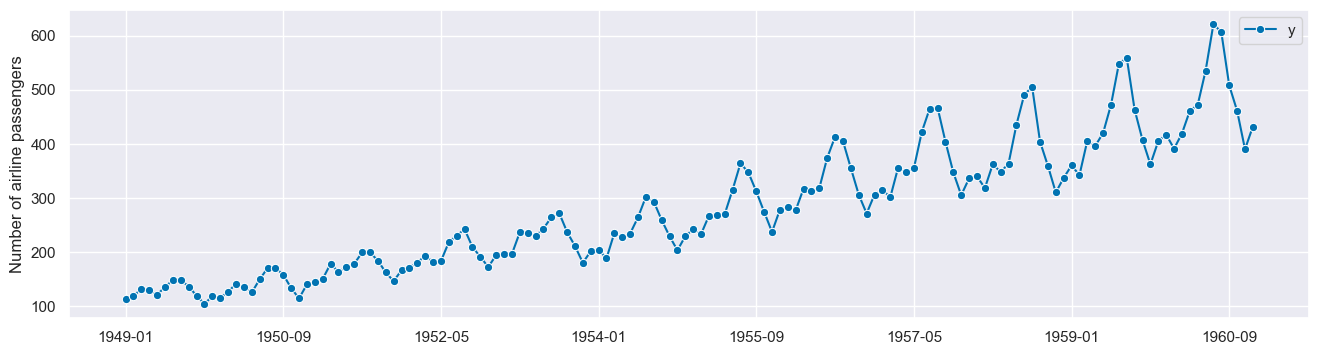

In [5]:
# Get our airline data:
y = load_airline()
plot_series(y, labels=["y"])

# Instantiate:
forecaster = NaiveForecaster()

# Fit:
forecaster.fit(y)

In [7]:

# An sktime ForecastingHorizon object:
sktime_fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)

# numpy arrays are also valid:
simple_fh = np.arange(1, 37)

print(
    f"The sktime Forecasting Horizon:\n\n {sktime_fh}"
    " \n\n The simple numpy based Forecasting Horizon:"
    " \n\n {simple_fh} \n\n Both work!!"
)

The sktime Forecasting Horizon:

 ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False) 

 The simple numpy based Forecasting Horizon: 

 {simple_fh} 

 Both work!!


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

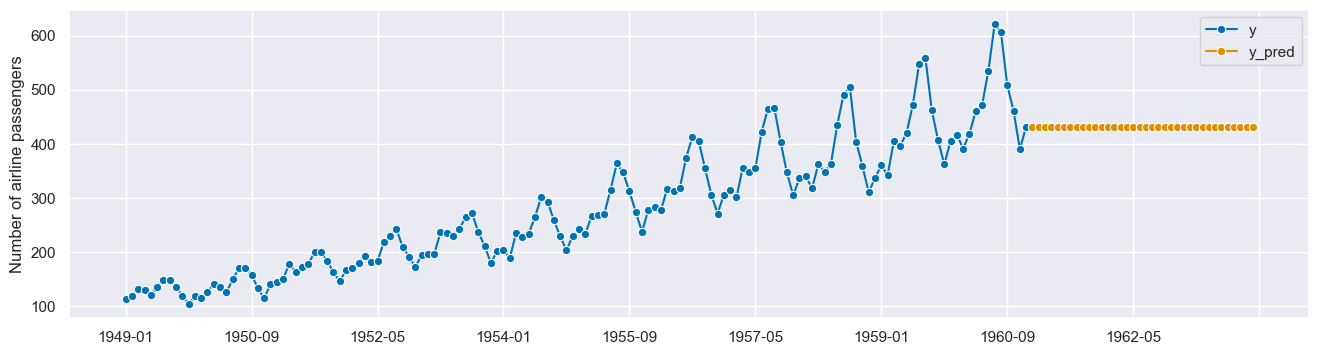

In [8]:
# Predict:
y_pred = forecaster.predict(sktime_fh)

# Check it out:
plot_series(y, y_pred, labels=["y", "y_pred"])

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

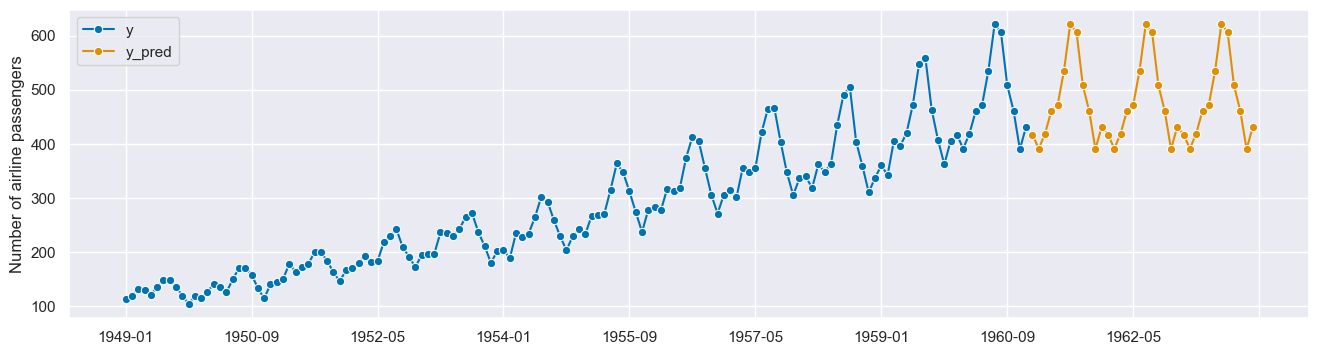

In [9]:
# Instantiate:
forecaster = NaiveForecaster(sp=12)

# Fit:
forecaster.fit(y)

# Predict:
y_pred = forecaster.predict(sktime_fh)

# Check it out:
plot_series(y, y_pred, labels=["y", "y_pred"])

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

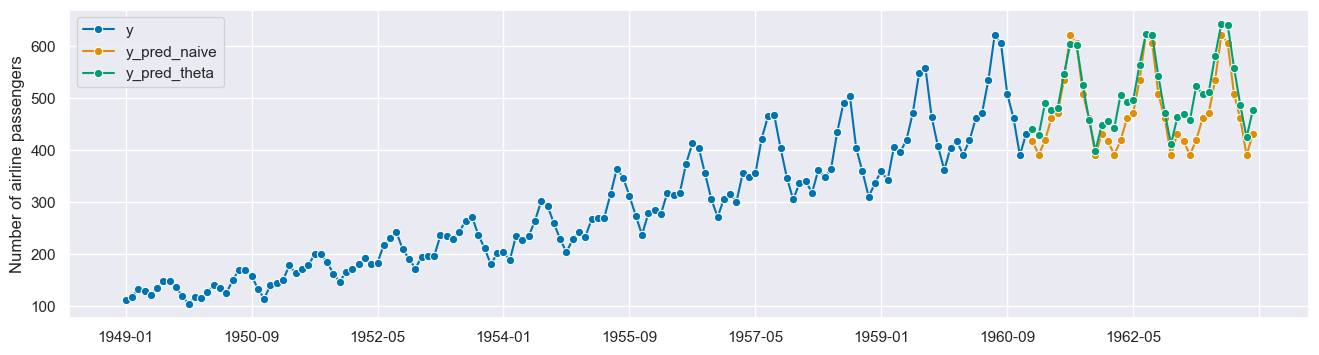

In [11]:

# Instantiate:
forecaster = ThetaForecaster(sp=12)

# Fit:
forecaster.fit(y)

# Predict:
y_pred_theta = forecaster.predict(sktime_fh)

# Check it out:
plot_series(y, y_pred, y_pred_theta, labels=["y", "y_pred_naive", "y_pred_theta"])